# Notebook 2: HMM Training, Analysis, and Visualization

**Objective:** Load the logged inference trajectories, train an HMM surrogate, analyze its learned states, and visualize its behavior on test reviews.

In [13]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle # to save data for clustering

# Add src directory to Python path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.config import (
    LOG_FILE_PATH, HMM_MODEL_PATH, TARGET_SENTIMENT,
    NUM_TEST_SAMPLES, MAX_TOKENS, MODEL_NAME, DEVICE, 
    COLOR_LOG_FILE_PATH, PLOT_SAVE_PATH
)

from src.hmm_surrogate import HMMSurrogate
from src.data_utils import load_imdb_data, preprocess_data_for_inference_logging
from src.black_box_model import BlackBoxSentimentClassifier, log_inference_trajectories
from src.visualization_utils import plot_state_timeline, plot_hmm_transition_matrix, plot_avg_probabilities_per_state
from src.clustering_utils import save_color_log
from src.convergence_utils import (plot_log_likelihoods, 
    save_convergence_data, plot_state_chain_acf, 
    posterior_predictive_check, mean_run_length,
    simulate_state_sequences,posterior_predictive_check_model_based)

%matplotlib inline

## 1. Load Logged Inference Trajectories

In [14]:
try:
    loaded_data = np.load(LOG_FILE_PATH)
    train_trajectories = [loaded_data[f'arr_{i}'] for i in range(len(loaded_data.files))]
    print(f"Loaded {len(train_trajectories)} trajectories from {LOG_FILE_PATH}.")
    if train_trajectories:
        print(f"Example trajectory 0 shape: {train_trajectories[0].shape}")
except FileNotFoundError:
    print(f"Error: Log file {LOG_FILE_PATH} not found. Please run Notebook 1 first.")
    train_trajectories = []

Loaded 25000 trajectories from data/imbd_inference_logs25k.npz.
Example trajectory 0 shape: (512, 2)


## 2. Train HMM Surrogate

In [15]:
# hmm_surrogate_model = None
# if train_trajectories:
#     hmm_surrogate_model = HMMSurrogate() # Uses N_HMM_STATES from config
#     hmm_surrogate_model.train(train_trajectories)
    
#     # Save the trained HMM model
#     if not os.path.exists('models'):
#         os.makedirs('models')
#     hmm_surrogate_model.save_model(HMM_MODEL_PATH)
# else:
#     print("Skipping HMM training as no trajectories were loaded.")

In [16]:
# hmm_surrogate_model = HMMSurrogate.load_model(HMM_MODEL_PATH)

## 3. Analyze HMM Parameters and States

If you didn't just train, you can load a pre-trained HMM model.

In [17]:
hmm_surrogate_model = None

Attempting to load pre-trained HMM from models/sentiment_hmm25k_4states.pkl
HMM model loaded from models/sentiment_hmm25k_4states.pkl

--- HMM Parameters ---
Initial state probabilities (startprob_):
 [0.00000000e+000 1.00000000e+000 0.00000000e+000 5.37242129e-283]

Transition matrix (transmat_):
 [[9.96086421e-01 0.00000000e+00 7.78136453e-07 3.91280045e-03]
 [8.73818280e-04 0.00000000e+00 7.26633199e-03 9.91859850e-01]
 [4.06340986e-05 0.00000000e+00 9.94756391e-01 5.20297473e-03]
 [7.00619751e-03 2.10316161e-41 8.11990557e-03 9.84873897e-01]]

Emission probabilities (means_ for GaussianHMM):
 [[0.98723543 0.01276457]
 [0.35785007 0.64214998]
 [0.01603069 0.98396931]
 [0.49455074 0.50544926]]

Emission covariances (covars_ for GaussianHMM):
 [[[ 8.09619411e-05 -8.09525074e-05]
  [-8.09525074e-05  8.09619414e-05]]

 [[ 4.00000000e-07  3.99999948e-07]
  [ 3.99999948e-07  3.99999912e-07]]

 [[ 1.33502958e-04 -1.33493685e-04]
  [-1.33493685e-04  1.33502958e-04]]

 [[ 1.13576994e-01 -1.1

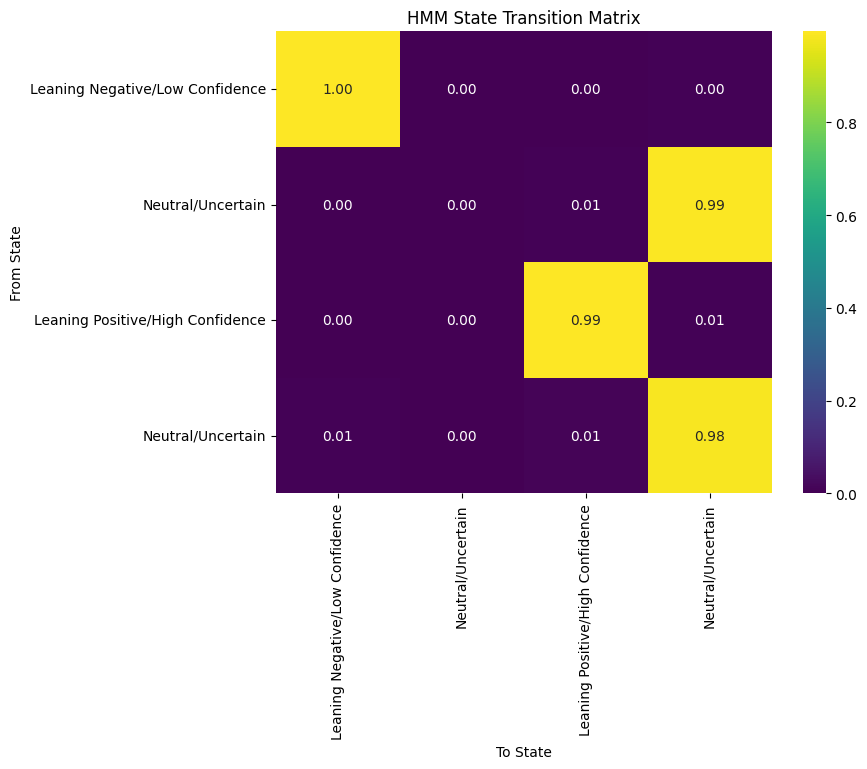

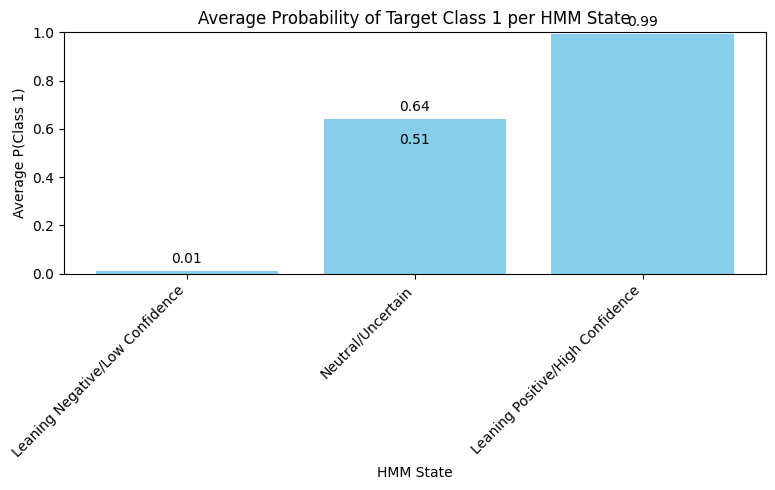

In [18]:
if hmm_surrogate_model is None or not hmm_surrogate_model.is_trained:
    print(f"Attempting to load pre-trained HMM from {HMM_MODEL_PATH}")
    try:
        hmm_surrogate_model = HMMSurrogate()
        hmm_surrogate_model.load_model(HMM_MODEL_PATH)
    except FileNotFoundError:
        print(f"Error: Pre-trained HMM model not found at {HMM_MODEL_PATH}. Please train one first.")
        hmm_surrogate_model = None # Ensure it's None if loading fails

state_analysis_results = None
if hmm_surrogate_model and hmm_surrogate_model.is_trained and train_trajectories:
    # For state analysis, we need decoded states for the training trajectories
    decoded_train_states = [hmm_surrogate_model.decode_sequence(traj) for traj in train_trajectories if traj.shape[0] > 0]
    
    # Filter out empty sequences from train_trajectories if their decoded_train_states are empty
    valid_train_trajectories = [traj for traj, states in zip(train_trajectories, decoded_train_states) if states.size > 0]
    valid_decoded_train_states = [states for states in decoded_train_states if states.size > 0]
    
    state_analysis_results = hmm_surrogate_model.analyze_states(
        valid_train_trajectories, 
        valid_decoded_train_states, 
        target_class_idx=TARGET_SENTIMENT
    )
    
    # Visualize HMM parameters
    plot_hmm_transition_matrix(hmm_surrogate_model.model, state_names=state_analysis_results.get('state_names'))
    plot_avg_probabilities_per_state(state_analysis_results, target_class_idx=TARGET_SENTIMENT)

Save data for convergence diagnostics

In [19]:
# Make sure the directory exists
os.makedirs("notebooks/convergence_diagnostics", exist_ok=True)

# Save using pickle
with open("notebooks/convergence_diagnostics/valid_decoded_train_states.pkl", "wb") as f:
    pickle.dump(valid_decoded_train_states, f)
print("Convergence data saved successfully!")

Data saved successfully!


## 4. Visualize HMM Behavior on Test Reviews

Load a few test reviews, get their black-box probability trajectories, decode HMM states, and plot.


--- Visualizing HMM on Test Reviews ---
Model loaded successfully on cpu
loaded black box model: lvwerra/distilbert-imdb
Labels: {0: 'NEGATIVE', 1: 'POSITIVE'}


Processing data: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.16s/it]



Visualizing Test Sample 1:
Text: I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Bab...

Sentence tokens with HMM colors:
[CLS] i love sci - fi and am willing to put up with a lot . sci - fi movies 



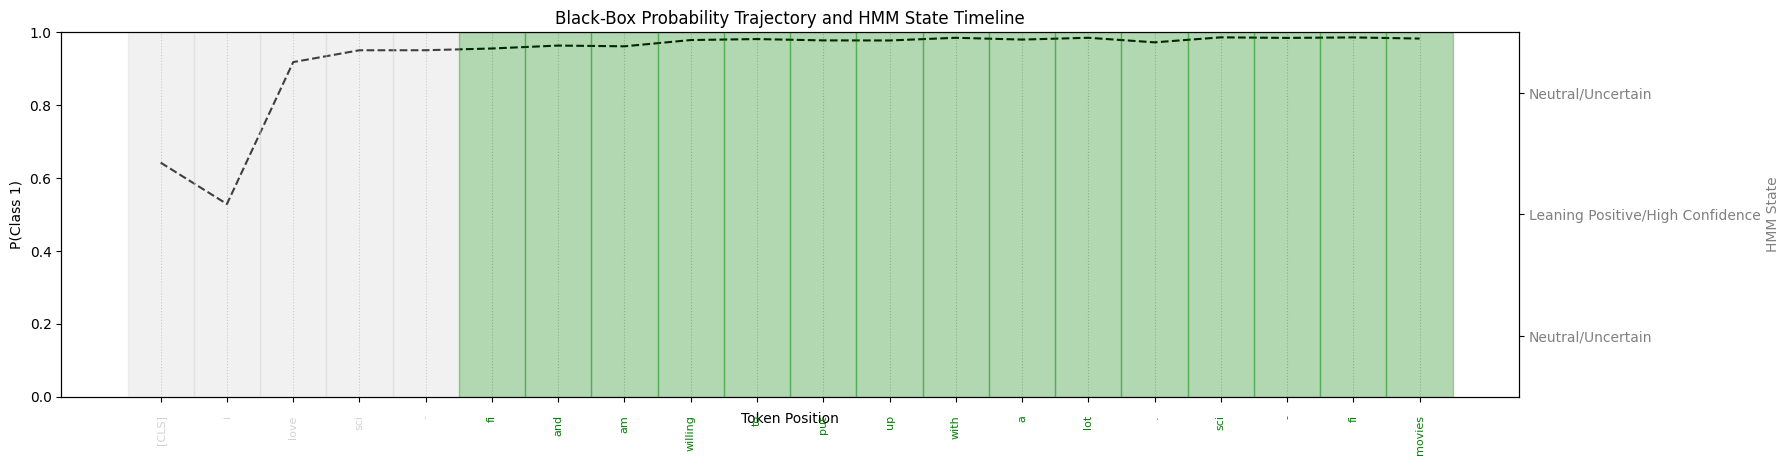

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 2:
Text: Worth the entertainment value of a rental, especially if you like action movies. This one features the usual car chases, fights with the great Van Damme kick style, shooting battles with the 40 shell ...

Sentence tokens with HMM colors:
[CLS] worth the entertainment value of a rental , especially if you like action movies . this one features the 



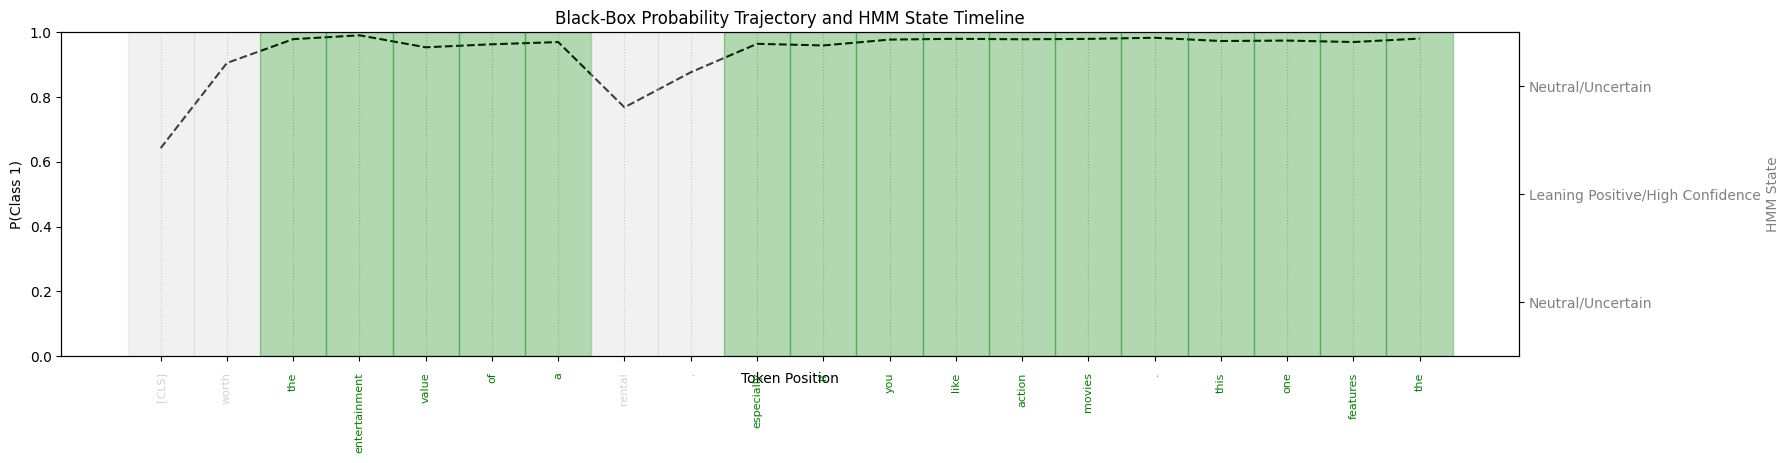

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 3:
Text: its a totally average film with a few semi-alright action sequences that make the plot seem a little better and remind the viewer of the classic van dam films. parts of the plot don't make sense and s...

Sentence tokens with HMM colors:
[CLS] its a totally average film with a few semi - alright action sequences that make the plot seem a 



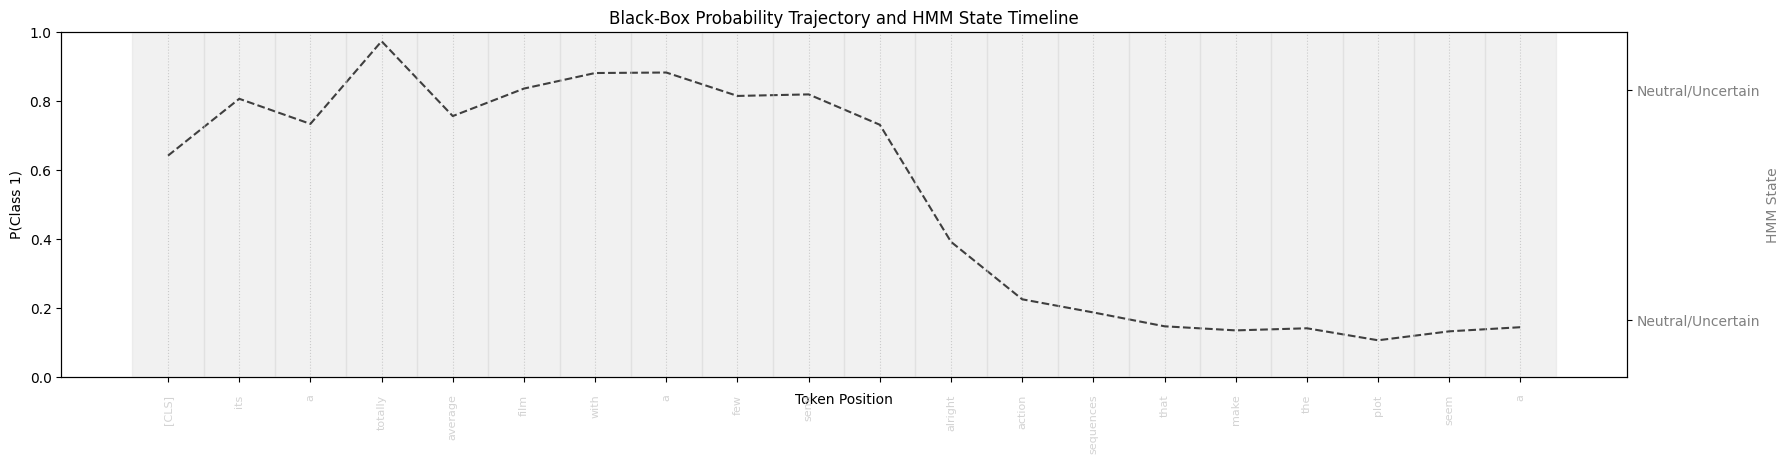

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 4:
Text: STAR RATING: ***** Saturday Night **** Friday Night *** Friday Morning ** Sunday Night * Monday Morning <br /><br />Former New Orleans homicide cop Jack Robideaux (Jean Claude Van Damme) is re-assigne...

Sentence tokens with HMM colors:
[CLS] star rating : * * * * * saturday night * * * * friday night * * * 



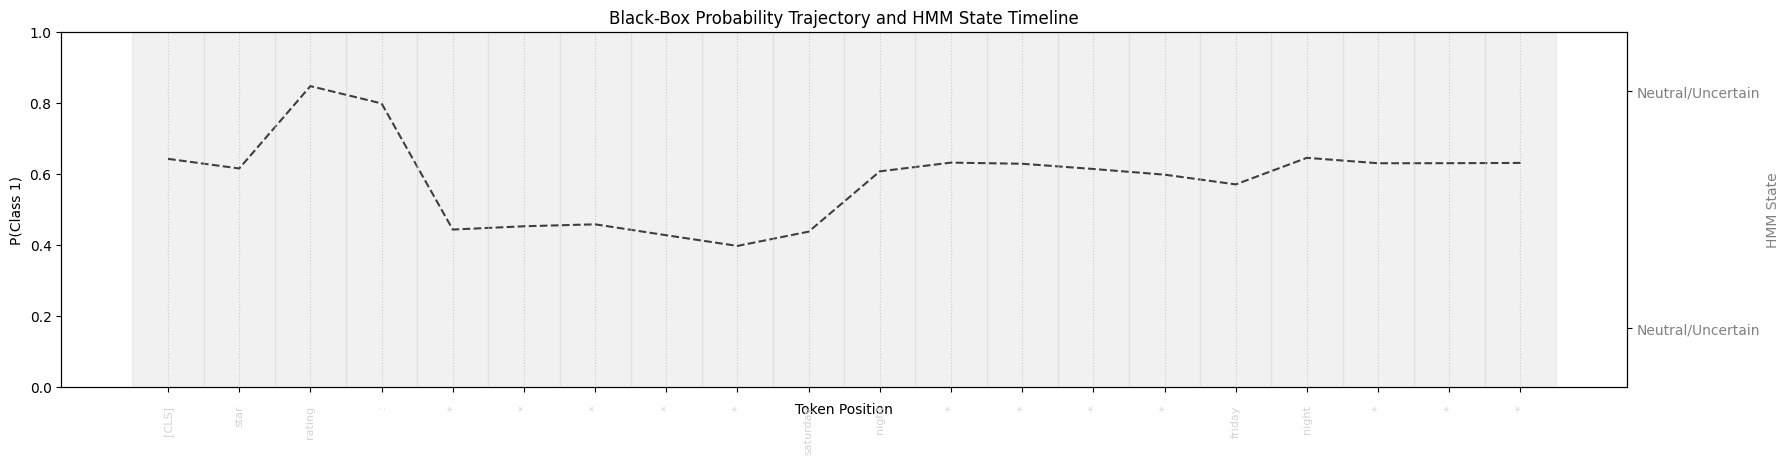

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 5:
Text: First off let me say, If you haven't enjoyed a Van Damme movie since bloodsport, you probably will not like this movie. Most of these movies may not have the best plots or best actors but I enjoy thes...

Sentence tokens with HMM colors:
[CLS] first off let me say , if you haven ' t enjoyed a van dam ##me movie since blood 



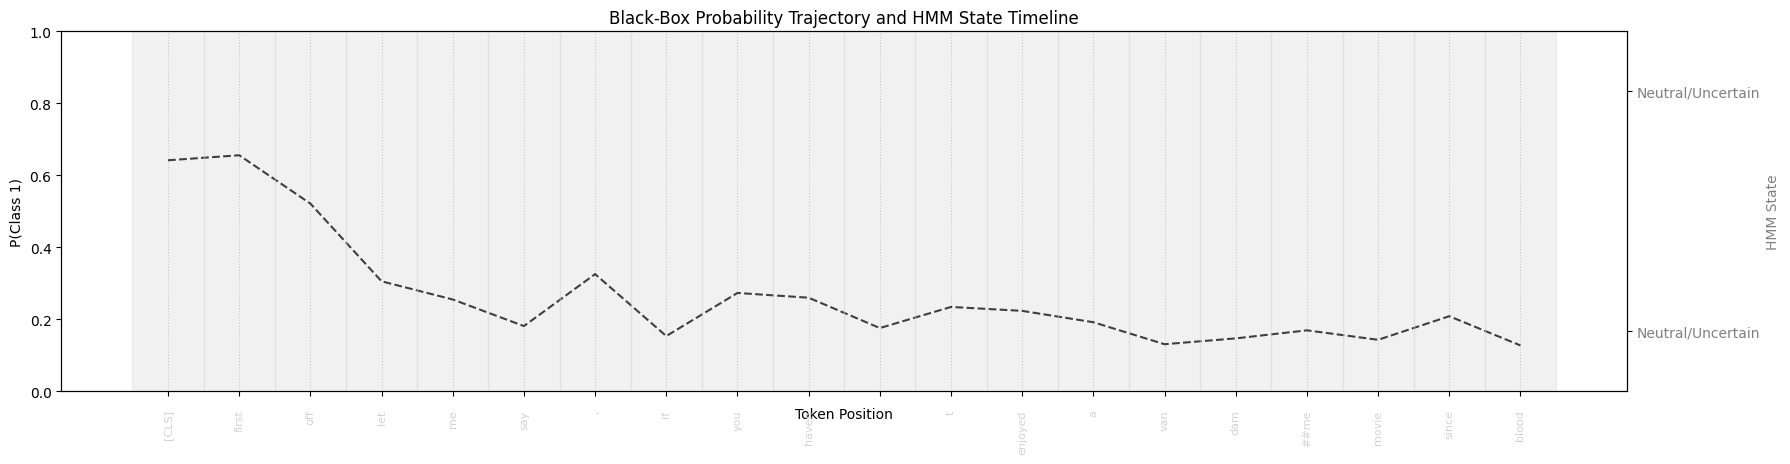

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 6:
Text: I had high hopes for this one until they changed the name to 'The Shepherd : Border Patrol, the lamest movie name ever, what was wrong with just 'The Shepherd'. This is a by the numbers action flick t...

Sentence tokens with HMM colors:
[CLS] i had high hopes for this one until they changed the name to ' the shepherd : border patrol 



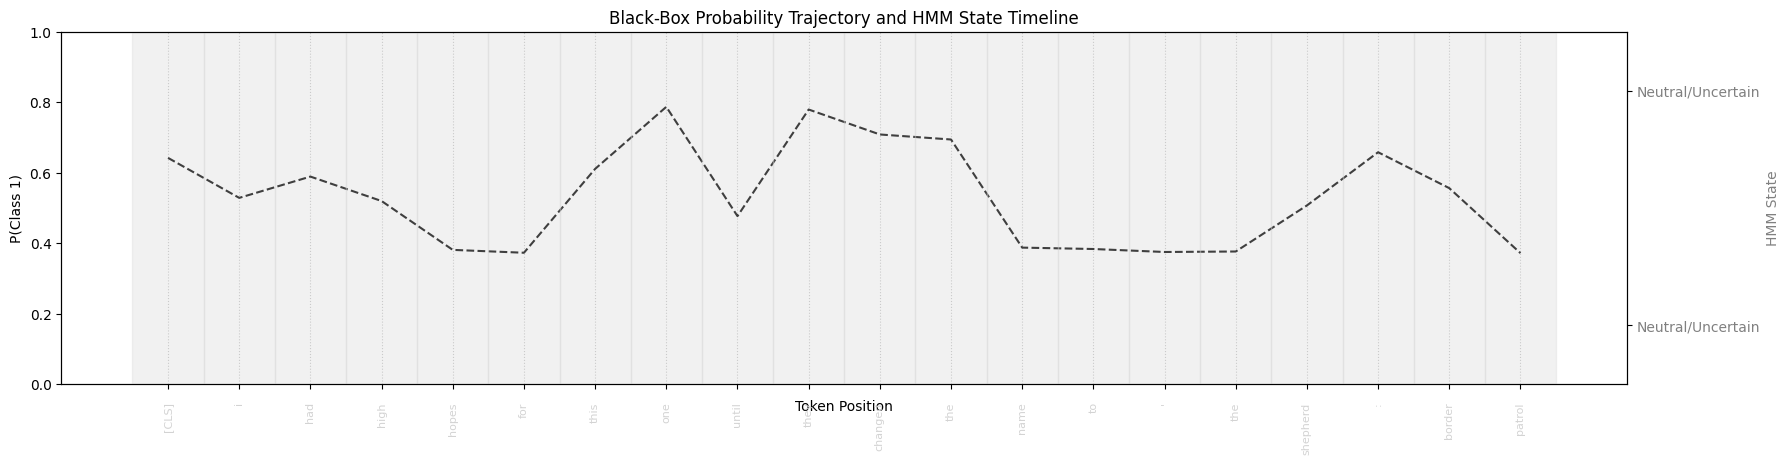

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 7:
Text: Isaac Florentine has made some of the best western Martial Arts action movies ever produced. In particular US Seals 2, Cold Harvest, Special Forces and Undisputed 2 are all action classics. You can te...

Sentence tokens with HMM colors:
[CLS] isaac fl ##ore ##ntine has made some of the best western martial arts action movies ever produced . in 



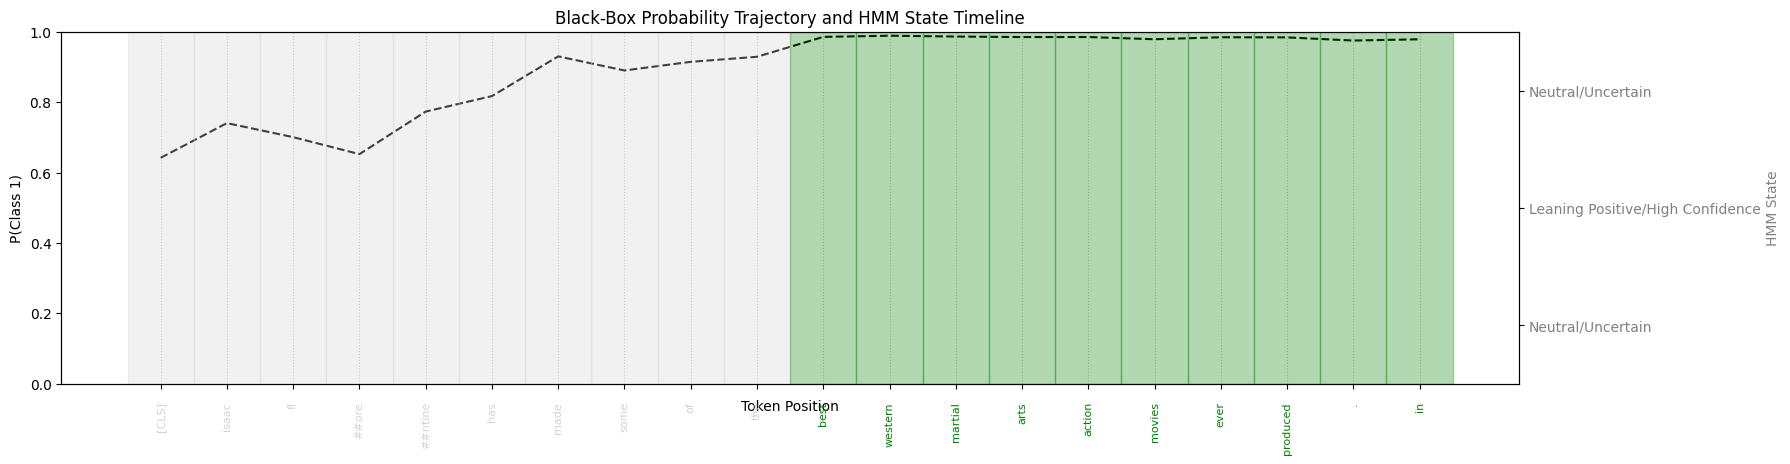

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 8:
Text: It actually pains me to say it, but this movie was horrible on every level. The blame does not lie entirely with Van Damme as you can see he tried his best, but let's face it, he's almost fifty, how m...

Sentence tokens with HMM colors:
[CLS] it actually pains me to say it , but this movie was horrible on every level . the blame 



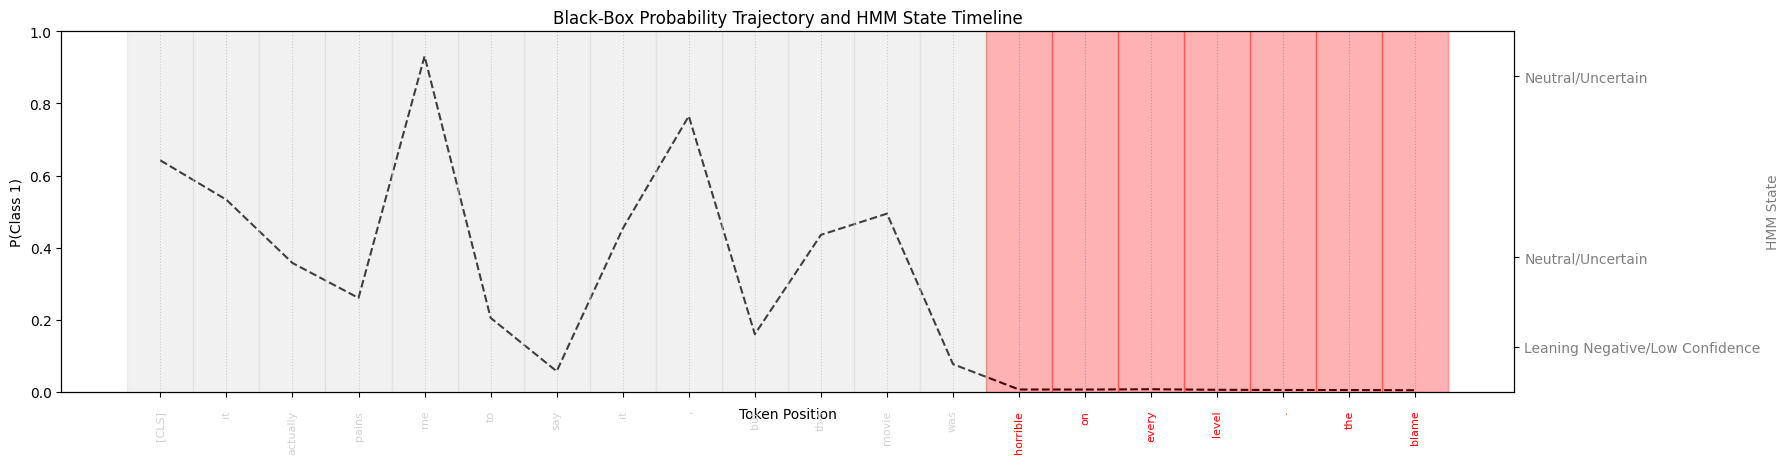

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 9:
Text: Technically I'am a Van Damme Fan, or I was. this movie is so bad that I hated myself for wasting those 90 minutes. Do not let the name Isaac Florentine (Undisputed II) fool you, I had big hopes for th...

Sentence tokens with HMM colors:
[CLS] technically i ' am a van dam ##me fan , or i was . this movie is so bad 



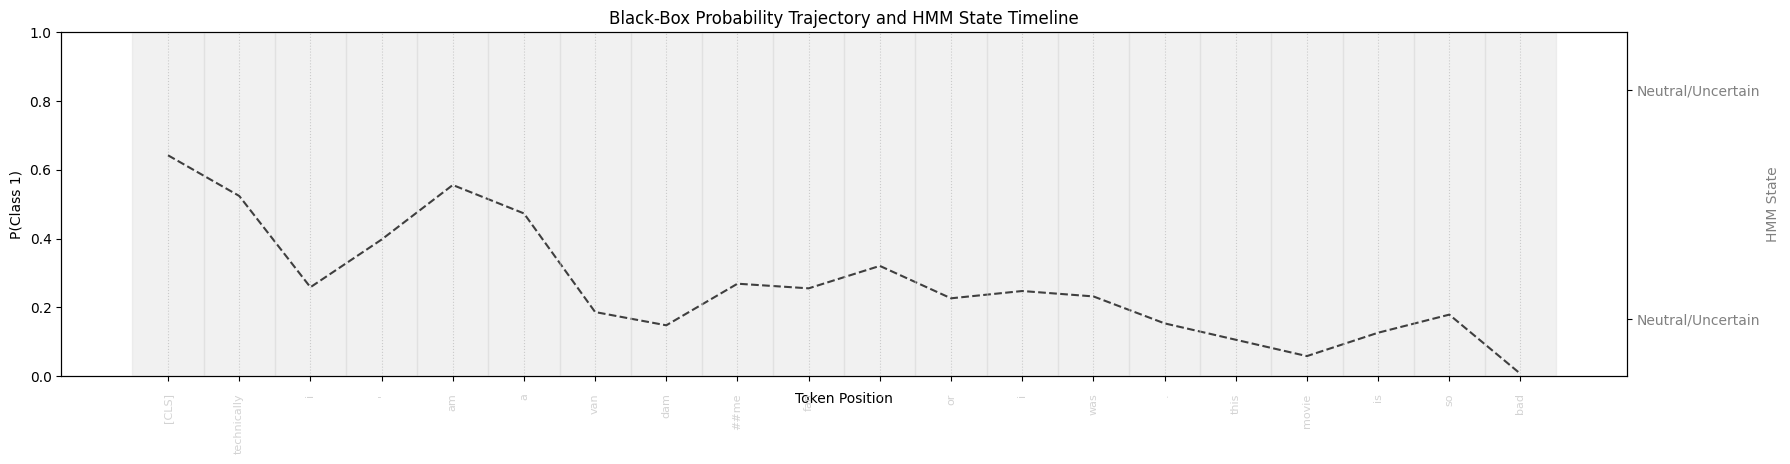

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 10:
Text: Honestly awful film, bad editing, awful lighting, dire dialog and scrappy screenplay.<br /><br />The lighting at is so bad there's moments you can't even see what's going on, I even tried to playing w...

Sentence tokens with HMM colors:
[CLS] honestly awful film , bad editing , awful lighting , dire dial ##og and scrap ##py screenplay . < 



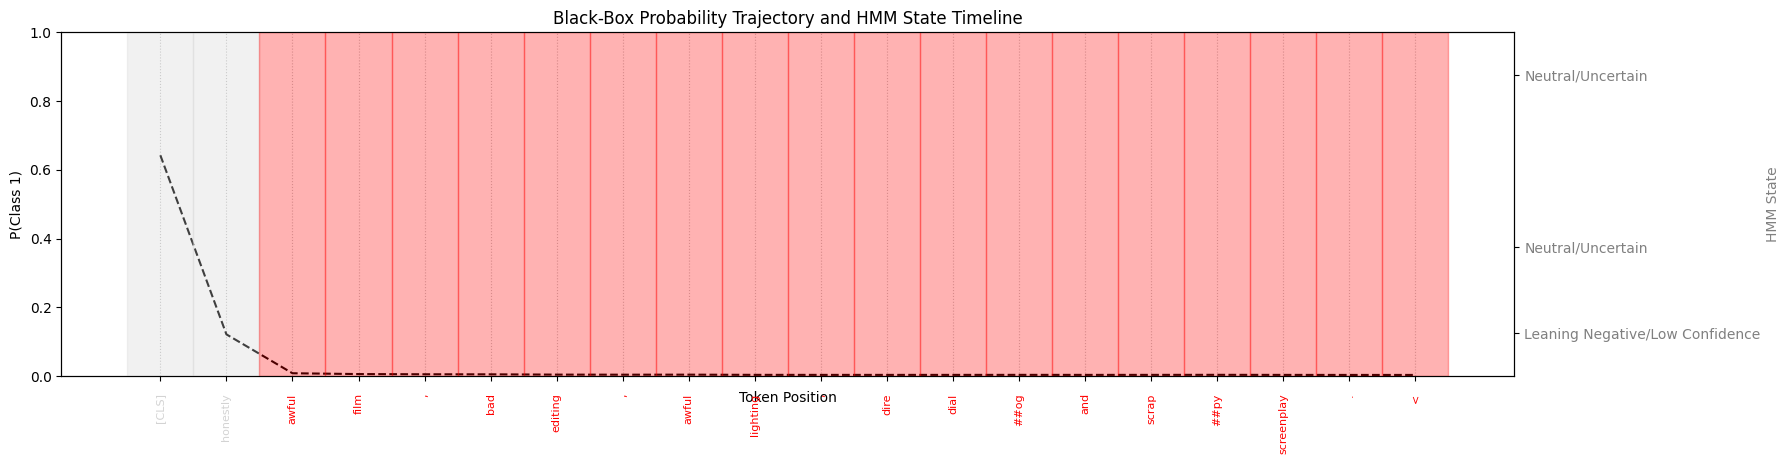

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 11:
Text: This flick is a waste of time.I expect from an action movie to have more than 2 explosions and some shooting.Van Damme's acting is awful. He never was much of an actor, but here it is worse.He was def...

Sentence tokens with HMM colors:
[CLS] this flick is a waste of time . i expect from an action movie to have more than 2 



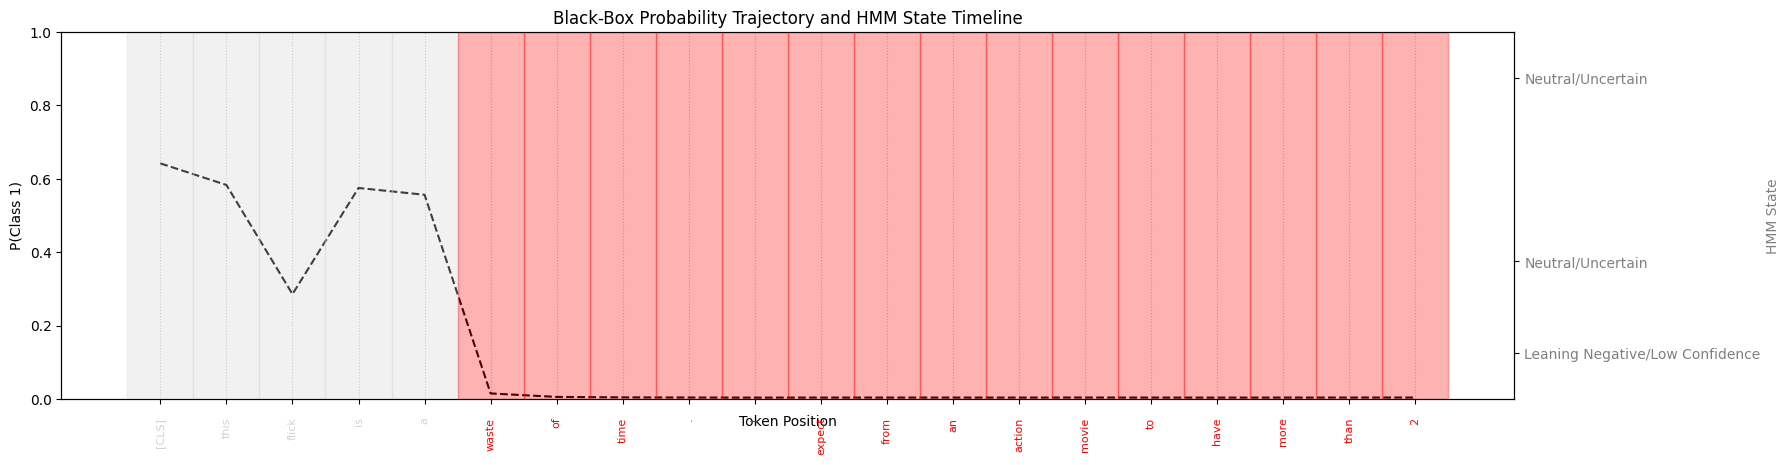

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 12:
Text: Blind Date (Columbia Pictures, 1934), was a decent film, but I have a few issues with this film. First of all, I don't fault the actors in this film at all, but more or less, I have a problem with the...

Sentence tokens with HMM colors:
[CLS] blind date ( columbia pictures , 1934 ) , was a decent film , but i have a few 



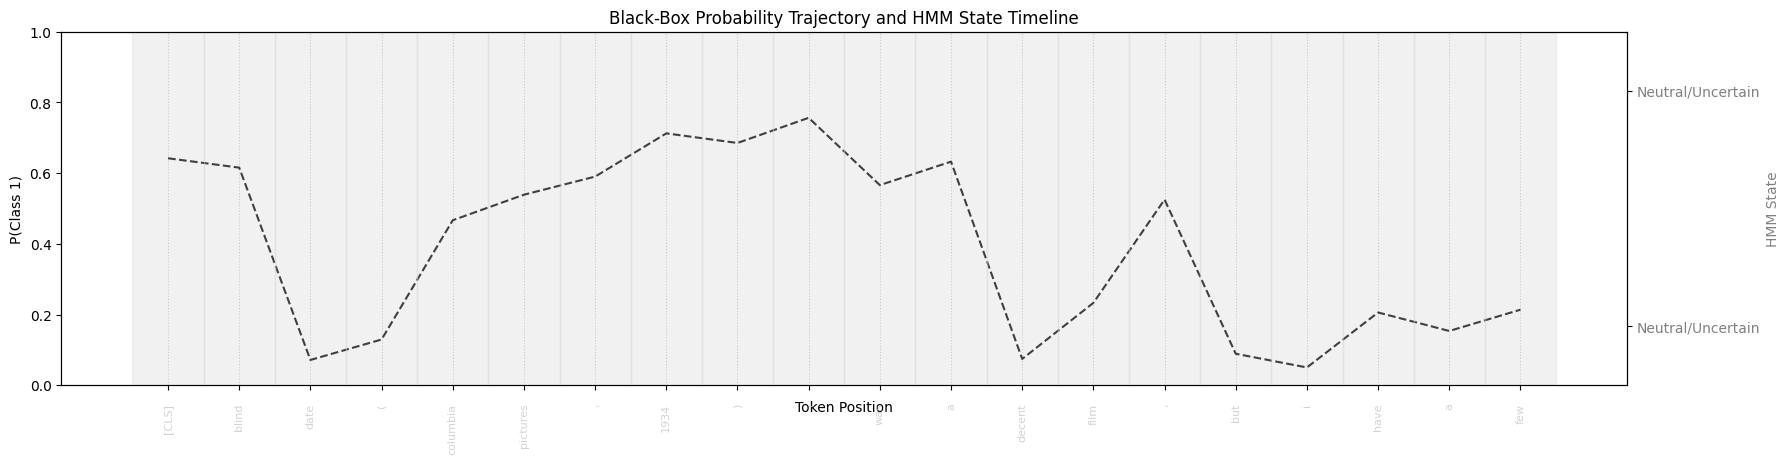

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 13:
Text: I first watched this movie back in the mid/late 80's, when I was a kid. We couldn't even get all the way through it. The dialog, the acting, everything about it was just beyond lame.<br /><br />Here a...

Sentence tokens with HMM colors:
[CLS] i first watched this movie back in the mid / late 80 ' s , when i was a 



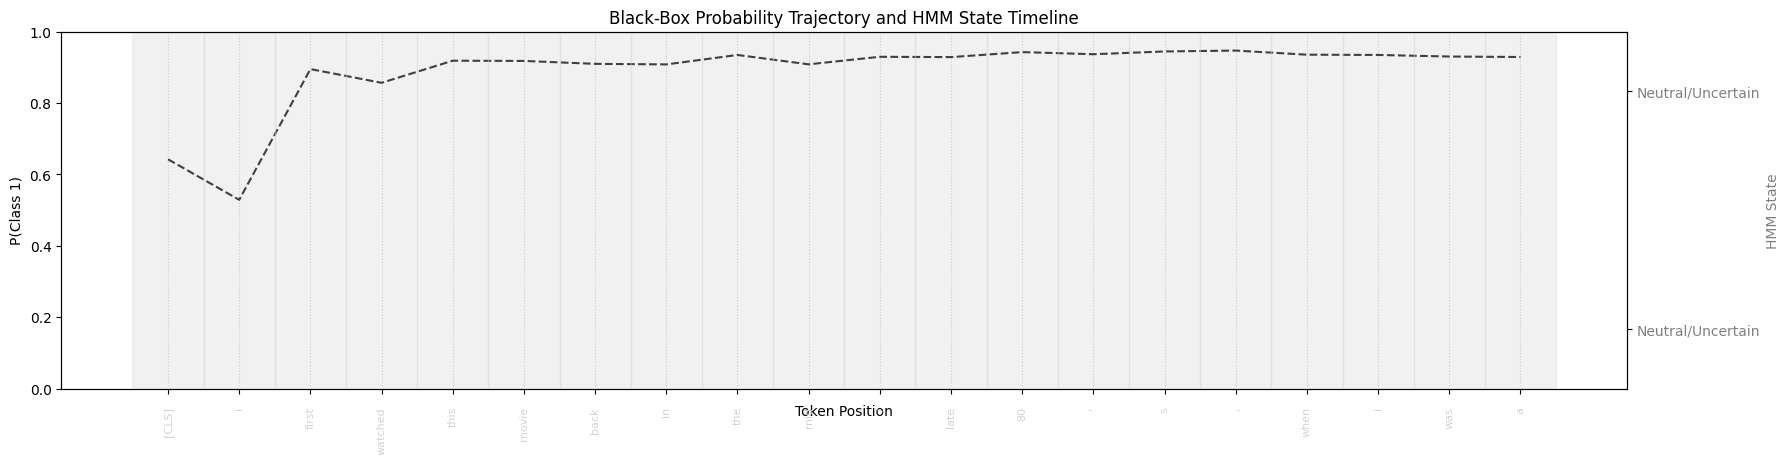

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 14:
Text: I saw the Mogul Video VHS of this. That's another one of those old 1980s distributors whose catalog I wish I had!<br /><br />This movie was pretty poor. Though retitled "Don't Look in the Attic," the ...

Sentence tokens with HMM colors:
[CLS] i saw the mo ##gul video vhs of this . that ' s another one of those old 1980s 



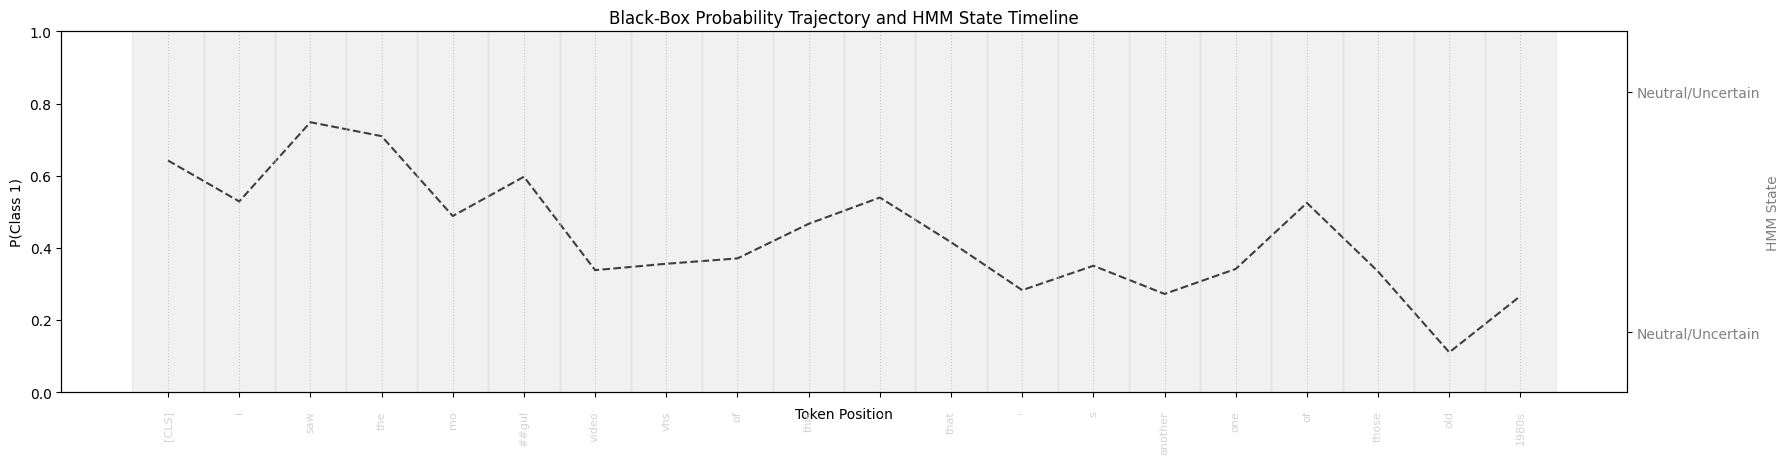

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 15:
Text: A group of heirs to a mysterious old mansion find out that they have to live in it as part of a clause in the will or be disinherited, but they soon find out of its history of everybody whom had lived...

Sentence tokens with HMM colors:
[CLS] a group of heirs to a mysterious old mansion find out that they have to live in it as 



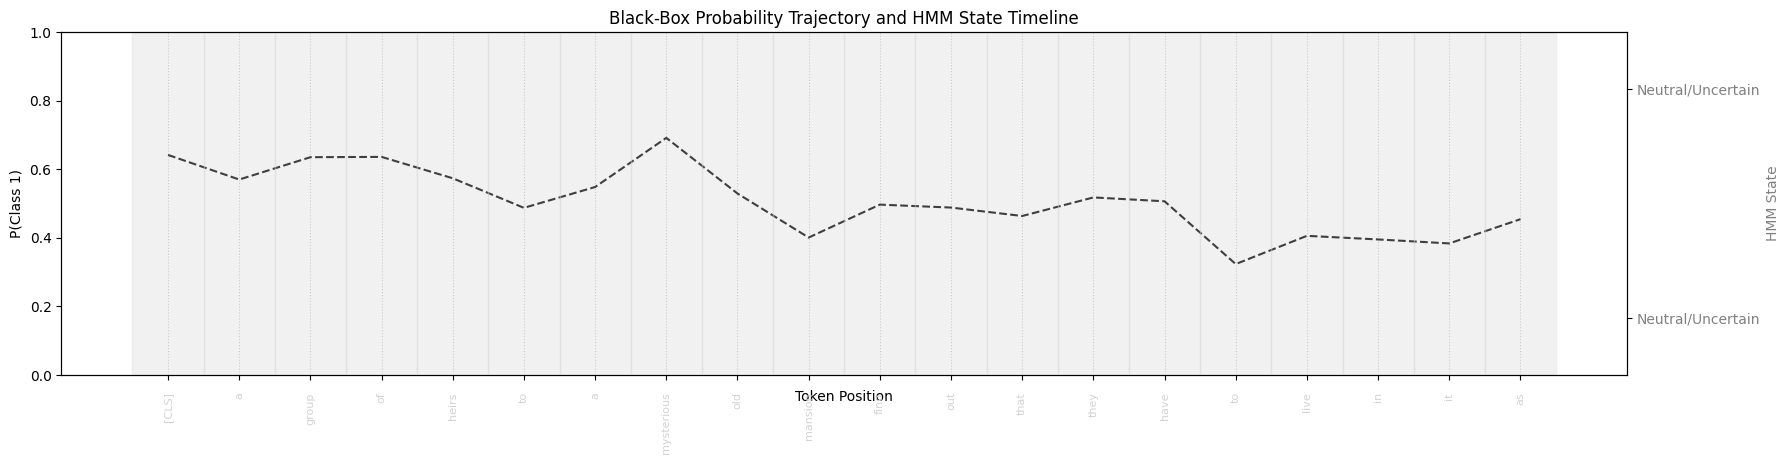

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 16:
Text: Now, I LOVE Italian horror films. The cheesier they are, the better. However, this is not cheesy Italian. This is week-old spaghetti sauce with rotting meatballs. It is amateur hour on every level. Th...

Sentence tokens with HMM colors:
[CLS] now , i love italian horror films . the che ##es ##ier they are , the better . however 



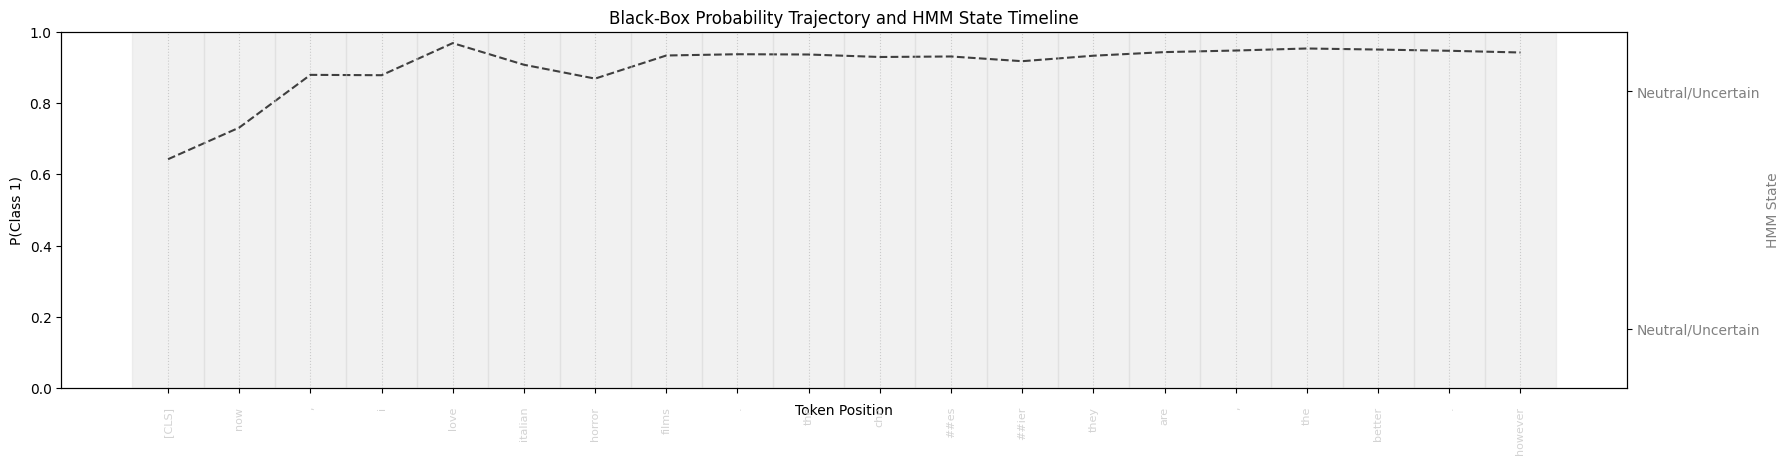

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 17:
Text: This cheap, grainy-filmed Italian flick is about a couple of inheritors of a manor in the Italian countryside who head up to the house to stay, and then find themselves getting killed off by ghosts of...

Sentence tokens with HMM colors:
[CLS] this cheap , grain ##y - filmed italian flick is about a couple of inherit ##ors of a manor 



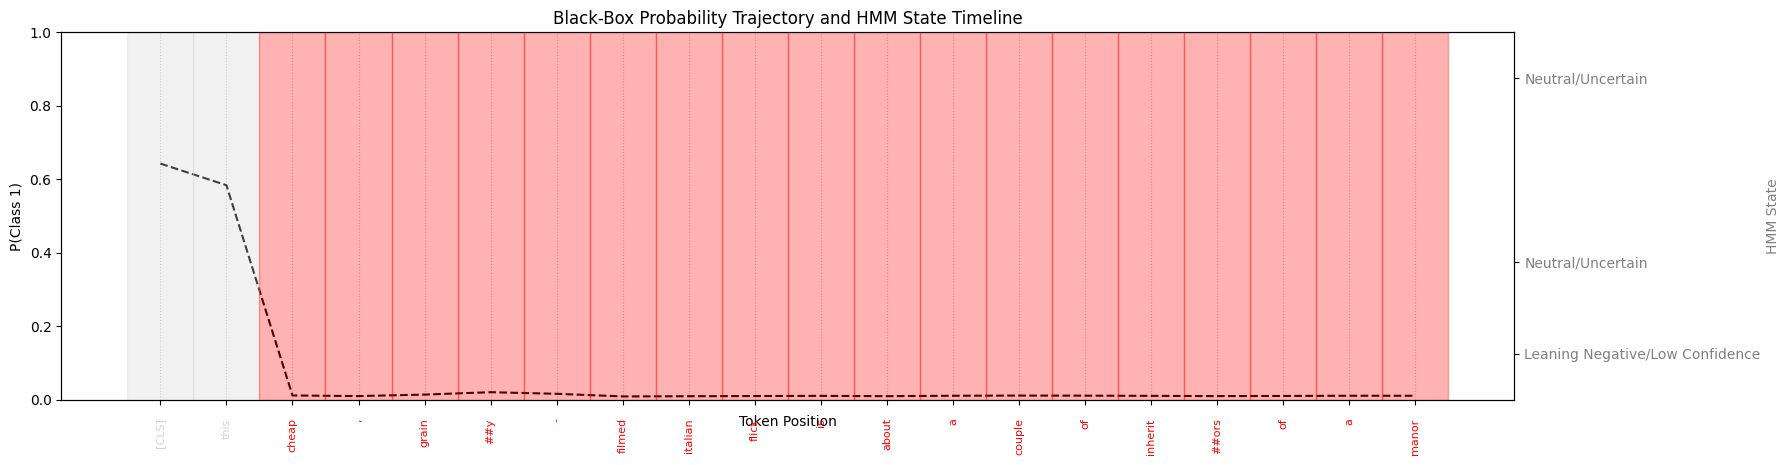

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 18:
Text: I just finished watching this movie and am disappointed to say that I didn't enjoy it a bit. It is so slow Slow and uninteresting. This kid from Harry Potter plays a shy teenager with an rude mother, ...

Sentence tokens with HMM colors:
[CLS] i just finished watching this movie and am disappointed to say that i didn ' t enjoy it a 



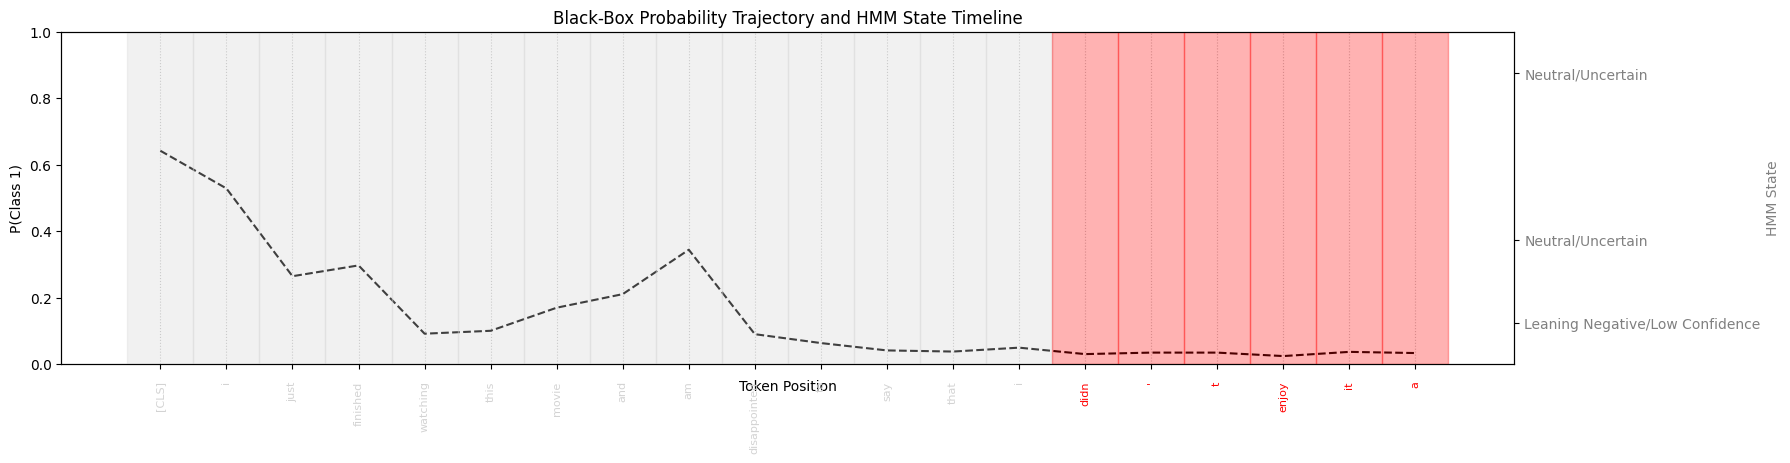

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 19:
Text: Ben, (Rupert Grint), is a deeply unhappy adolescent, the son of his unhappily married parents. His father, (Nicholas Farrell), is a vicar and his mother, (Laura Linney), is ... well, let's just say sh...

Sentence tokens with HMM colors:
[CLS] ben , ( rupert grin ##t ) , is a deeply unhappy adolescent , the son of his un 



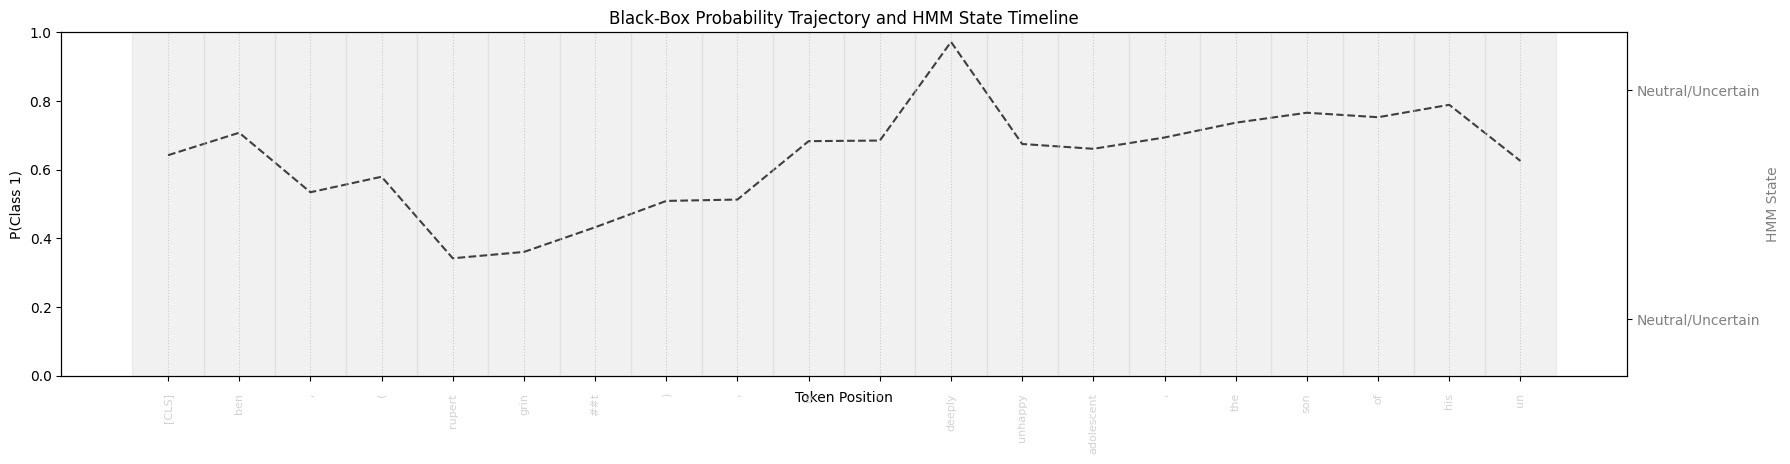

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 20:
Text: Every movie I have PPV'd because Leonard Maltin praised it to the skies has blown chunks! Every single one! When will I ever learn?<br /><br />Evie is a raving Old Bag who thinks nothing of saying she...

Sentence tokens with HMM colors:
[CLS] every movie i have pp ##v ' d because leonard mal ##tin praised it to the skies has blown 



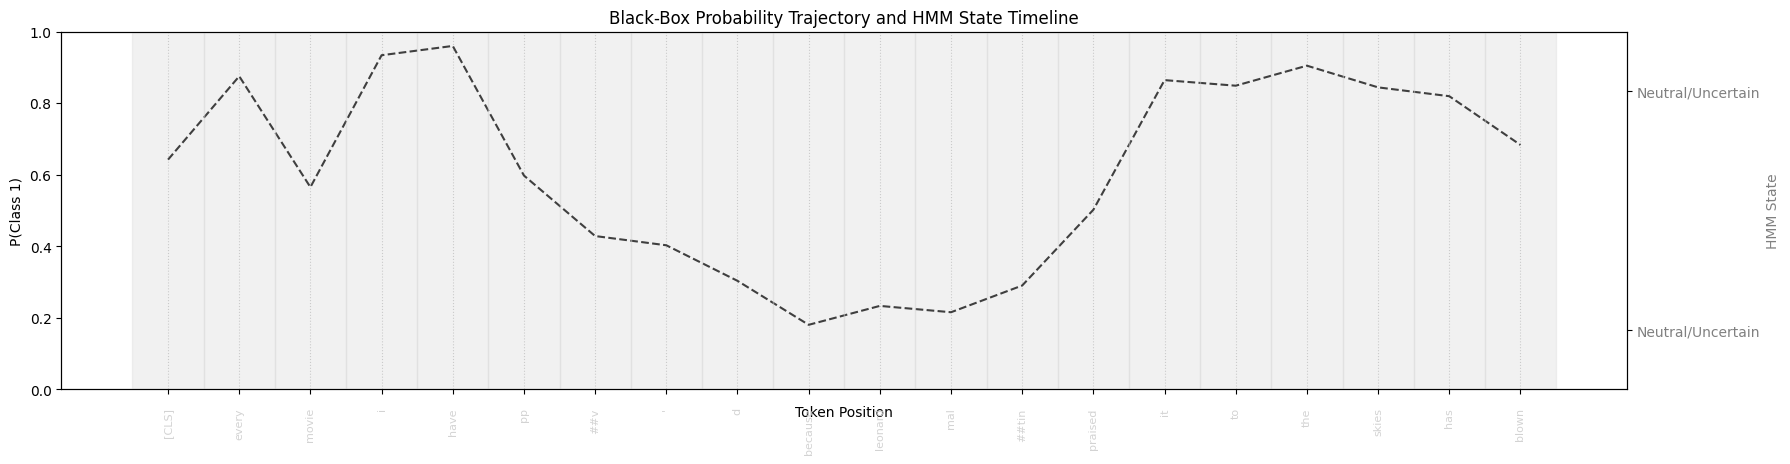

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl


In [21]:
if hmm_surrogate_model and hmm_surrogate_model.is_trained and state_analysis_results:
    print("\n--- Visualizing HMM on Test Reviews ---")
    # Load black-box model for generating test trajectories
    bb_model_vis = BlackBoxSentimentClassifier(model_name=MODEL_NAME, device=DEVICE)
    tokenizer_vis = bb_model_vis.tokenizer

    # Load some test data
    imdb_test_raw = load_imdb_data(split='test', num_samples=NUM_TEST_SAMPLES, shuffle=False)
    processed_test_data = preprocess_data_for_inference_logging(imdb_test_raw, tokenizer_vis)

    # Get trajectories for test data
    test_trajectories_vis = log_inference_trajectories(processed_test_data, bb_model_vis, max_len=MAX_TOKENS)
    
    # Get the actual tokens for each processed test sample (up to MAX_TOKENS)
    test_tokens_vis = []
    for item in processed_test_data:
        # Ensure [CLS] is handled consistently if present
        cls_token_id = tokenizer_vis.cls_token_id
        actual_tokens = item['tokens']
        if cls_token_id is not None and item['input_ids'][0] == cls_token_id:
             # If CLS is already first, use tokens directly
             pass # actual_tokens = item['tokens']
        elif cls_token_id is not None:
             # Prepend [CLS] token string if model adds ID but it's not in original 'tokens'
             actual_tokens = [tokenizer_vis.cls_token] + item['tokens']
        
        test_tokens_vis.append(actual_tokens[:MAX_TOKENS])


    for i, (prob_traj, tokens) in enumerate(zip(test_trajectories_vis, test_tokens_vis)):
        if prob_traj.shape[0] == 0: continue # Skip empty trajectories

        decoded_states_vis = hmm_surrogate_model.decode_sequence(prob_traj)
        
        # Ensure token list length matches trajectory length for plotting
        # The trajectory length is min(len(original_tokens_with_cls), MAX_TOKENS)
        # The `tokens` list should be sliced to match this length.
        plot_tokens = tokens[:len(decoded_states_vis)]

        print(f"\nVisualizing Test Sample {i+1}:")
        print(f"Text: {processed_test_data[i]['text'][:200]}...")
        
        plt.figure(figsize=(18, 6))
        plot_state_timeline(
            plot_tokens,
            prob_traj,
            decoded_states_vis,
            state_names=state_analysis_results.get('state_names'),
            target_class_idx=TARGET_SENTIMENT,
            ax=plt.gca() # Pass current axes
        )
        plt.show()
        
else:
    print("Skipping visualization as HMM model is not available or not trained, or state analysis is missing.")

Save color logs and data for clustering

In [22]:
save_color_log()

np.save("data/clustering/test_trajectories_vis.npy", np.array(test_trajectories_vis, dtype=object))
with open("data/clustering/test_tokens_vis.pkl", "wb") as f:
    pickle.dump(test_tokens_vis, f)
with open("data/clustering/decoded_states_vis.pkl", "wb") as f:
    pickle.dump(decoded_states_vis, f)
print("Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl")

Color logs saved!


# 5. Convergence diagnostics

[Useful reference for understanding the topic](https://stats.stackexchange.com/questions/115157/what-are-posterior-predictive-checks-and-what-makes-them-useful)
Check if our observed sequences significantly differ from random permutations (!! not sure about the utility/relevance of this).


--- HMM Convergence Check ---
Converged: True
Number of iterations: 55
Tolerance: 0.0001
Final log-likelihood: 67862697.4412


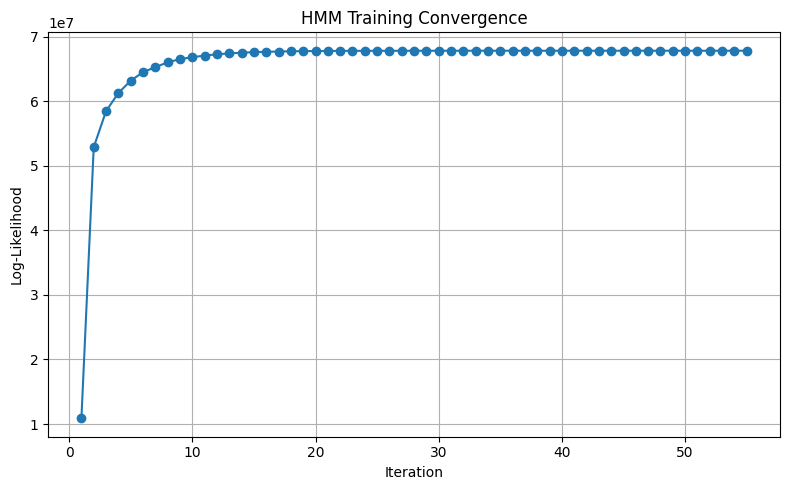

Convergence plot saved to 'notebooks/plots'.
Convergence data saved to 'convergence_diagnostics/convergence_data.pkl'.


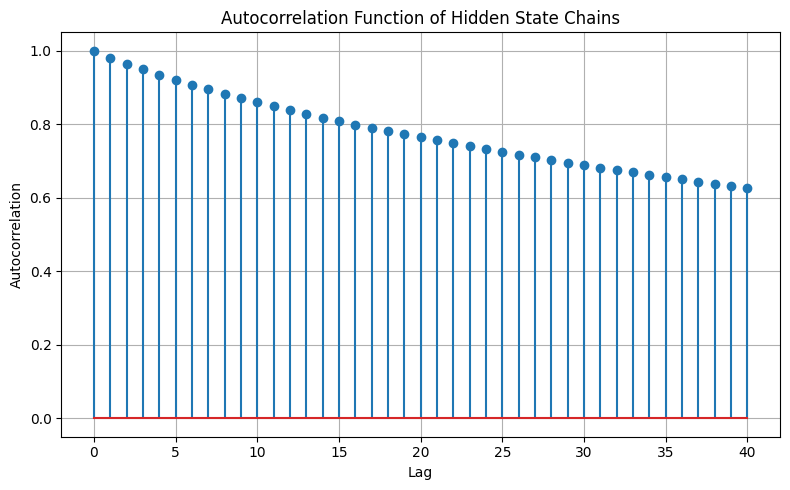

ACF plot saved to 'convergence_diagnostics/state_chain_acf.png'.
Observed summary: 71.481
Mean simulated summary: 11.399
Posterior predictive p-value: 0.028
Posterior predictive p-value for mean run length: 0.028


In [23]:
convergence_diagnostics = None

if hmm_surrogate_model and hmm_surrogate_model.is_trained:
    convergence_diagnostics = hmm_surrogate_model.check_convergence()
    plot_log_likelihoods(convergence_diagnostics["log_likelihoods"], convergence_diagnostics["n_iter"], save_path=PLOT_SAVE_PATH)
    save_convergence_data(convergence_diagnostics)
    

if valid_decoded_train_states:
    # Plot autocorrelation of hidden state chains
    plot_state_chain_acf(valid_decoded_train_states, max_lag=40, save_path="convergence_diagnostics/state_chain_acf.png")
    
    assert np.all(np.array([len(i) for i in valid_decoded_train_states]) > 0), "some state sequences have length 0"
    # Posterior predictive check for mean run length
    observed_mean_run_length = np.mean([mean_run_length(seq) for seq in valid_decoded_train_states])
    p_value, simulated_summaries = posterior_predictive_check(
        valid_decoded_train_states,
        summary_func=mean_run_length,
        observed_value=observed_mean_run_length,
        num_simulations=1000
    )
    print(f"Posterior predictive p-value for mean run length: {p_value:.3f}")

# Posterior predictive check (model-generated samples)
Check if our trained model can faithfully simulate sequences of states similar to those observed in the data 
One would expect this to be quite persistent: transitions between states are rare due to the sequential structure of language. 

In [ ]:
if valid_decoded_train_states:
    sequence_lengths = [len(seq) for seq in valid_decoded_train_states]
    
    # Generate simulated sequences from the trained model
    simulated_sequences = simulate_state_sequences(
        hmm_model=hmm_surrogate_model.model,
        sequence_lengths=sequence_lengths,
        num_simulations=100
    )
    
    # Compute the observed summary statistic
    observed_mean_run_length = np.mean([
        mean_run_length(seq) for seq in valid_decoded_train_states
    ])
    
    # Run the PPC with model-based simulations
    p_value, simulated_summaries = posterior_predictive_check_model_based(
        observed_state_sequences=valid_decoded_train_states,
        simulated_state_sequences=simulated_sequences,
        summary_func=mean_run_length,
        observed_value=observed_mean_run_length
    )
    
    print(f"Model-based posterior predictive p-value for mean run length: {p_value:.3f}")

What does this mean? 
Our simulated data is not significantly different from observed data in terms of state persistence: the model is very sticky and this reflects also in the simulated data, with an average sequence length with the same token of 52. 
### This corroborates our convergence analysis, and we can say that the HMM model with 4 states captures the structure of sentiment change in the transformer quite well.